In [43]:
import pandas as pd

In [44]:
df = pd.read_csv("/kaggle/input/imdb-movies-review/IMDB Dataset.csv")

In [45]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [46]:
embedding_dim = 300   # Dimension of pre-trained embedding
max_words = 215658    
max_length = 200 

In [48]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-11-15 11:55:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-11-15 11:55:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-11-15 11:55:57--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: 'glove.6B.zip'

glov

In [49]:
embedding_index = {}
with open('/kaggle/working/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        embedding_index[word] = vector

In [52]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df['review'])
sequences = tokenizer.texts_to_sequences(df['review'])
word_index = tokenizer.word_index

In [53]:
# Pad sequences to the same length
data = pad_sequences(sequences, maxlen=max_length)

In [56]:
print(data[1])

[    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     3   393   120   353     7     7     1  1385  2977     6    52 17949
    52   155    55  2381  1582     2   411     3 13283     2   530 26559
   282     4  1847     5     1   438   412     7     7     1   150    23
   568    69  2274   498  4571    21    61    45   189    29     1 71839
    18    28    45    29     1  2294   175  3336    96    22    67   371
    63     1 13740   791  9719    31     1  1825     5 12144  7366  6594
    21    61     6     9    69   278     1   147    18     9     6     3
 38710   407     2  2406   412     3  4339   353    42    27     4     1
    78 16060     4   202     2    24   114     7     7     1  1847    62
   270   344    16     1   120   177     1  1029     4     1  2924    60
   248    71   356     1  2206 56311  3127  1289  1

In [55]:
# Create embedding matrix
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [58]:
y = df['sentiment'].values

In [63]:
# Assuming y contains labels like ['positive', 'negative']
label_mapping = {'positive': 1, 'negative': 0}
y = [label_mapping[label] for label in y]

In [64]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [65]:
# Build the model
model = Sequential([
    Embedding(
        input_dim=max_words,
        output_dim=embedding_dim,
        weights=[embedding_matrix],  
        input_length=max_length,
        trainable=False              
    ),
    Bidirectional(LSTM(64, return_sequences=False)),  
    Dropout(0.5),                                    
    Dense(64, activation='relu'),                     
    Dropout(0.5),                                     
    Dense(1, activation='sigmoid')                    
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [71]:
# Convert y_train and y_test to numpy arrays with dtype float32
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [72]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_test, y_test)
)

Epoch 1/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 24s 17ms/step - accuracy: 0.6769 - loss: 0.5829 - val_accuracy: 0.8386 - val_loss: 0.3910
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8592 - loss: 0.3389 - val_accuracy: 0.8679 - val_loss: 0.3206
Epoch 3/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8799 - loss: 0.2871 - val_accuracy: 0.8805 - val_loss: 0.2819
Epoch 4/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.8944 - loss: 0.2568 - val_accuracy: 0.8776 - val_loss: 0.2882
Epoch 5/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 17ms/step - accuracy: 0.9123 - loss: 0.2259 - val_accuracy: 0.8948 - val_loss: 0.2642


In [73]:
import matplotlib.pyplot as plt 

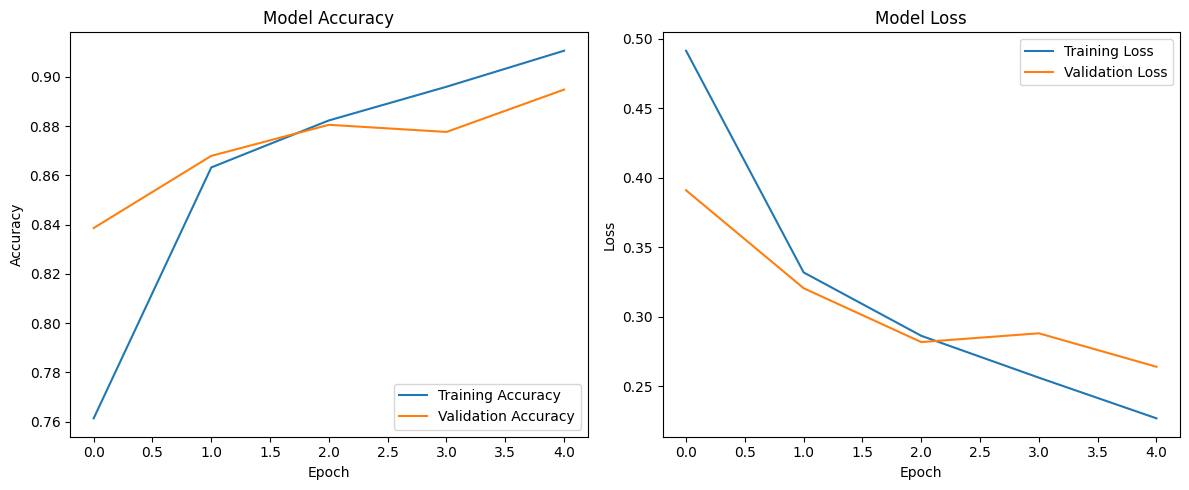

In [74]:
# Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()


In [76]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)


In [79]:
model.save("/kaggle/working/sentiment_model.h5")

In [80]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the tokenizer and model
# Ensure you save and reload your tokenizer correctly
import pickle
with open('/kaggle/working/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

model = load_model('/kaggle/working/sentiment_model.h5')  # Replace with your model file

In [81]:
# Function to preprocess input text
def preprocess_review(review, tokenizer, max_length):
    # Tokenize the input review
    sequences = tokenizer.texts_to_sequences([review])
    # Pad the sequence to match the model's input length
    padded_sequence = pad_sequences(sequences, maxlen=max_length)
    return padded_sequence

In [82]:
# Function to predict sentiment
def predict_sentiment(review, tokenizer, model, max_length):
    # Preprocess the review
    processed_review = preprocess_review(review, tokenizer, max_length)
    # Get the prediction
    prediction = model.predict(processed_review)
    # Interpret the result
    sentiment = "positive" if prediction[0][0] > 0.5 else "negative"
    confidence = prediction[0][0] if prediction[0][0] > 0.5 else 1 - prediction[0][0]
    return sentiment, confidence

In [87]:
# Input and prediction
review = input("Enter a review ")
max_length = 200 

# Predict sentiment
sentiment, confidence = predict_sentiment(review, tokenizer, model, max_length)

# Output result
print(f"Review sentiment: {sentiment} (Confidence: {confidence:.2f})")

Enter a review  this movie is trash


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Review sentiment: negative (Confidence: 0.97)
